# Getting Started
This homework uses OpenAI's Gym. If you don't have Gym installed, head over to https://gym.openai.com/docs/ for instructions. We recommend Python 3.6 for this assignment.


In [ ]:
%matplotlib inline
import numpy as np
import gym
from tqdm import tqdm # progress bar
import matplotlib.pyplot as plt
import math
import random

def flipCoin( p ):
    r = random.random()
    return r < p

# Intro
In this assignment you will explore model-based and model-free reinforcement learning methods applied to a classic control problem called CartPole. The problem, as described by OpenAI:

*A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the cente*

A more detailed description can be found at https://github.com/openai/gym/wiki/CartPole-v0

Model-based reinforcement learning consists of two main parts: learning
a dynamics model, and using a controller to plan and execute actions that
minimize a cost function.

Model-free reinforcement learning does not attempt to learn how the environment changes from one state to the other with each action, instead this method directly estimates the action with the highest utility given a state.



In this notebook, we will explore the model-based approach. Suppose *s*, *a*, and *s'* denote state, action and the next state respectively. We will learn the function that maps *(s, a) -> s'*. Then we will select actions using the dynamics model to evaluate future states.

## a)
In order to learn the dynamics model for the environment, you must first collect data *(s, a) -> s'*. Fill in the following function to gather a dataset. Starting with initial state, sample an action randomly, step the environment to get the next state. Repeat until the episode is over. Perfrom this procedure for num_rollouts episodes. 

In [2]:
env = gym.make('CartPole-v0')
max_rollout_length = 200

def gather_random_dataset(num_rollouts):
    states, actions, next_states = [], [], []
    for _ in tqdm(range(num_rollouts)):
            state = env.reset()
            done = False
            t = 0
            while not done:
                action = np.random.choice([0, 1]) # flip a coin to sample a random action. Valid action is either 0 or 1
                next_state, reward, done, _ = env.step(action)
                done = done or (t >= max_rollout_length)
                # save the data to corresponding arrays
                states.append(state)
                actions.append(action)
                next_states.append(next_state)
                state = next_state
                t += 1
    return np.array(states), np.array(actions)[:, None], np.array(next_states)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
states, actions, next_states = gather_random_dataset(100)

100%|██████████| 100/100 [00:00<00:00, 1947.11it/s]


## b)
You will now model the environment with a polynomial dynamics function. First, augment the state with two additional features partiuclarly useful for this problem - cosine and sine of theta. Then concatenate augmented states and actions, and use those as input to make polynomial features. Fit the polynomial coefficients using OLS.

*Why polynomials?* As you may have noticed from the description, CartPole is not a terribly complex task. In fact, the motion can be described by a differential equation - this kind of intuition is valuable when choosing a learning method. In this case, you know the structure of the environment, but you don't know the parameters - the weight of the cart, the length and weight of the pole, etc. It turns out that a polynomial model can learn the combinations of these unknowns to accurately model transitions.

/Users/maksimivanov/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


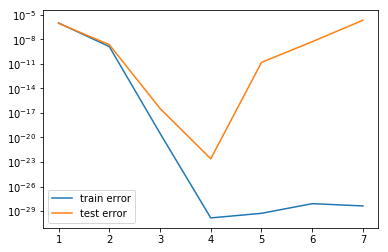

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


train_mses = []
test_mses = []

# augment observation cos(theta) and sin(theta)
states_aug = np.concatenate([states, np.cos(states[: , -2])[:, None], np.sin(states[: , -2])[:, None]],
                            axis = 1)
# concatenate state and action 
s_a = np.concatenate([states_aug, actions], axis = 1)
y = next_states
models = dict()

# make polynomial features from concatenated state-action
for deg in range(1, 8):
    polyFeatures = PolynomialFeatures(degree=deg)
    X = polyFeatures.fit_transform(s_a)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, shuffle=True)
    # our environment is noiseless so OLS will work
    w, _, _, _ = np.linalg.lstsq(X_train, y_train)
    models[deg] = (w, deg)
    y_pred = np.matmul(X_test,w)
    # compute error
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, np.matmul(X_train,w))
    train_mses.append(mse_train)
    test_mses.append(mse_test)

plt.figure()
xs = list(range(1,8))
plt.semilogy(xs, train_mses, label = 'train error')
plt.semilogy(xs, test_mses, label = 'test error')
plt.legend()


## c)
At this point you have picked a model for the environment, and you are ready to put it to work. Your agent will plan ahead by unrolling action sequences and evaluating the costs along the way, then picking the action sequence that corresponds to the lowest cost. Since this is a simple environment, we can afford to do an exhaustive search provided that the depth is reasonable. In a more complex setting (continuous, for example), you can fall back on something like a Monte-Carlo tree search.

First, build your predictor that maps *(s, a) -> s'* using your model. Then, implement the planning algorithm as described above. We have provided two different cost functions to choose when evaluate each state.

In [5]:
coeff, deg = models[4]
polyFeatures = PolynomialFeatures(degree=deg)


theta_threshold_radians = 12 * 4 * np.pi / 360
x_threshold = 5

def predict_next_states(states, actions):
    states_aug = np.concatenate([states, np.cos(states[: , 2])[:, None], np.sin(states[: , 2])[:, None]], axis = 1)
    s_a = np.concatenate([states_aug, actions[:, None]], axis = 1)
    X = polyFeatures.fit_transform(s_a)
    pred = np.matmul(X, coeff)
    pred = np.clip(pred, -10, 10)
    return pred

def coarse_cost_fn(states):
    x = states[:, 0]
    theta = states[:, 2]
    failed_x =  np.logical_or(x < -x_threshold, x > x_threshold)
    failed_theta = np.logical_or(theta < -theta_threshold_radians, theta > theta_threshold_radians)
    return -np.logical_not(np.logical_or(failed_x, failed_theta)).astype(np.int32)

def fine_cost_fn(states):
    x = states[:, 0]
    theta = states[:, 2]
    x_reward = np.min((x_threshold + x, x_threshold - x), axis = 0)
    theta_reward = np.min(((theta_threshold_radians + theta, theta_threshold_radians - theta)), axis= 0)
    return -(x_reward / x_threshold + theta_reward / theta_threshold_radians)

## try changing this  in part d) ##
cost_fn = coarse_cost_fn          #
###################################

def unroll(state, horizon):
    cur_state_cost = cost_fn(state[None, :])
    if horizon == 0 or cur_state_cost >= 0:
        return cur_state_cost
    prev_states = np.vstack([state, state])
    actions = np.array([0, 1])
    next_states = predict_next_states(prev_states, actions)
    costs = [unroll(next_states[0, :], horizon - 1), unroll(next_states[1, :], horizon - 1)]
    return cost_fn(state[None, :]) + np.min(costs)

def plan(state, horizon=5):
    prev_states = np.vstack([state, state])
    actions = np.array([0, 1])
    next_states = predict_next_states(prev_states, actions)
    costs = [unroll(next_states[0, :], horizon - 1), unroll(next_states[1, :], horizon - 1)]
    return np.argmin(costs)
        

                

## d)
Putting everything together: now it is time to evaluate the performance of your model-based agent. Run this first with `coarse_cost_fn`, which is the negative of the reward that the environment provides you.

You may find the results disappointing. If the environment is noise-less and the model is near-perfect, why does the agent perform so poorly?

Recall that the environment reward at step t is 1 if you survived and 0 if you died. This doesn't help you to differentiate non-dying states - e.g. a pole that is perfectly upright and a pole that is on the brink of falling look equally as good to your agent. While the model of the state space is very accurate, the model of the goal is simplistic ("just don't die"), so the agent is unable to play the game very well because it lacks a fine-grained understanding of the goal, and thus is unable to figure out the optimal action. 

In the second part of this homework, you will explore how model-free methods can help overcome this barrier. 

Repeat the experiment, but now with `fine_cost_fn` instead. This cost function will force a penalty on the agent proportional to how far the pole is leaning as well as how far the cart has moved from the center.

This agent should perform very well, beating the game as long as it gets to plan at least 2 steps ahead.

Under this cost function the agent has a better understanding of the optimal state, and thus it is able to utilize the state model to choose the optimal action.

In [6]:

def gather_rollouts(num_rollouts, horizon=3):
    states, actions, next_states = [], [], []
    for e in range(num_rollouts):
            state = env.reset()
            done = False
            t = 0
            r  = 0
            while not done:
                action = plan(state, horizon)
                next_state, reward, done, _ = env.step(action)
                done = done or (t >= max_rollout_length)
                # save the data to corresponding arrays
                if not done:
                    states.append(state)
                    actions.append(action)
                    next_states.append(next_state)
                    state = next_state
                r += reward
                t += 1
            print('Episode:', e)
            print('Return:', r)
            print('\n')
gather_rollouts(10, 2)

Episode: 0
Return: 200.0


Episode: 1
Return: 200.0


Episode: 2
Return: 200.0


Episode: 3
Return: 200.0


Episode: 4
Return: 200.0


Episode: 5
Return: 200.0


Episode: 6
Return: 200.0


Episode: 7
Return: 200.0


Episode: 8
Return: 200.0


Episode: 9
Return: 200.0




## e)
Now we contrast the previous planning approach with Q learning. In this Dynamic Programming approach, we create a table where we’ll calculate the maximum expected future reward, for each action at each state. This Q table will contain scores specifically, the value of each cell will be the maximum expected future reward for that given state and action.

First you want to initialize your q table to a table of zeros and specify values for hyperparameters such as learning rate, discount factor, etc.

Then for a specified period of time you will want to choose an action based on current Q value estimates or take a random action to explore the environment.

Finally we want to update the Q table with what we have seen so that it can make more informed decisions moving forward.

In [ ]:
env = gym.make('CartPole-v0')

Q = np.zeros((2,6,9,3,4))

c = 10

actions = [0,1]

epsilon=1.0

alpha=0.5

discount = 0.99

i=0

obs = env.reset()
running_reward = 0

for _ in range(3000):
    env.render()
    
    ## Map State to element in Q table
    if round(obs[0],2) <= obs[0]:
        index_1 = round(obs[0]+2.4,2)
        index_1 = int(round(index_1,0))
    else:
        index_1 = round(obs[0]+2.4,2)
        index_1 = int(round(index_1,0))
    if obs[3] <= -np.radians(16.67):
        index_3 = 0
    elif obs[3] >= -np.radians(16.67):
        index_3 = 2
    else:
        index_3 = 1
    if obs[1] <= -1:
        index_4 = 0
    elif obs[1] <= -0:
        index_4 = 1
    elif obs[1] <= 1:
        index_4 = 2
    else:
        index_4 = 3
    if round(obs[2],2) <= obs[2]:
        index_2 = (round(obs[2]+0.42,3)/0.1)
        index_2 = int(round(index_2,0))
    else:
        index_2 = round(obs[2]+0.42,3)/0.1
        index_2 = int(round(index_2,0))
        
        
    q_vals = [Q[act,index_1,index_2,index_3,index_4] for act in actions]
    actionerino = q_vals.index(max(q_vals))
    if flipCoin(epsilon):
        actionerino = random.choice(actions)
    obs, reward, done, info = env.step(actionerino) # take a random action
    running_reward += reward
    
    ## Map new State to element in Q table
    if obs[3] <= -np.radians(16.67):
        obs_index_3 = 0
    elif obs[3] >= -np.radians(16.67):
        obs_index_3 = 2
    else:
        obs_index_3 = 1
    if round(obs[2],2) <= obs[2]:
        obs_index_2 = (round(obs[2]+0.42,3)/0.1)
        obs_index_2 = int(round(obs_index_2,0))
    else:
        obs_index_2 = round(obs[2]+0.42,3)/0.1
        obs_index_2 = int(round(obs_index_2,0))
    if round(obs[0],2) <= obs[0]:
        obs_index_1 = round(obs[0]+2.4,2)
        obs_index_1 = int(round(obs_index_1,0))
    else:
        obs_index_1 = round(obs[0]+2.4,2)
        obs_index_1 = int(round(obs_index_1,0))
    if obs[1] <= -1:
        obs_index_4 = 0
    elif obs[1] <= -0:
        obs_index_4 = 1
    elif obs[1] <= 1:
        obs_index_4 = 2
    else:
        obs_index_4 = 3
        
    obs_q_vals = [Q[act,obs_index_1,obs_index_2,obs_index_3,obs_index_4] for act in actions]
    
    ## Update Q table values
    Q[actionerino,index_1,index_2,index_3,index_4] = (alpha*running_reward) 
    + ((1-alpha)*Q[actionerino,index_1,index_2,index_3,index_4])
    + (alpha*discount*(max(obs_q_vals))) - ((c)*abs(obs[0])) - ((c)*abs(obs[3]))
    
    ## Check if cartpole constraints were violated
    if done == True:
        epsilon = max(0.01, min(epsilon, 1.0 - np.log10((i + 1) / 25)))
        discount = max(0.5, min(discount, 1.0 - np.log10((i + 1) / 25)))
        alpha = max(0.1, min(alpha, 1.0 - np.log10((i + 1) / 25)))
        Q[actionerino,index_1,index_2,index_3,index_4] = -1000000000
        print(running_reward)
        running_reward = 0
        print("reset " + str(i))
        i += 1
        env.reset()

## Testing
Now that we are done training our Q learning agent we can test it to see how it performs compared to our Planning agent in the previous part.

In [ ]:
obs = env.reset()
running_reward = 0
while(True):
    env.render()
    index_1 = round(obs[0]+2.4, 2)
    index_1 = int(round(index_1, 0))
    index_2 = (round(obs[2]+0.42, 3) / 0.1)
    index_2 = int(round(index_2, 0))
    if obs[3] <= -np.radians(16.67):
        index_3 = 0
    elif obs[3] >= -np.radians(16.67):
        index_3 = 2
    else:
        index_3 = 1
    if obs[1] <= -1:
        index_4 = 0
    elif obs[1] <= -0:
        index_4 = 1
    elif obs[1] <= 1:
        index_4 = 2
    else:
        index_4 = 3
    q_vals = [Q[act,index_1,index_2,index_3,index_4] for act in actions]
    actionerino = q_vals.index(max(q_vals))
    obs, reward, done, info = env.step(actionerino)
    running_reward += reward
    if done == True:
        print(running_reward)
        running_reward = 0
        print("reset " + str(i))
        i += 1
        env.reset()

37.0
reset 144
14.0
reset 145
22.0
reset 146
30.0
reset 147
29.0
reset 148
19.0
reset 149
34.0
reset 150
32.0
reset 151
57.0
reset 152
12.0
reset 153
32.0
reset 154
19.0
reset 155
53.0
reset 156
15.0
reset 157
45.0
reset 158
31.0
reset 159
43.0
reset 160
13.0
reset 161
29.0
reset 162
52.0
reset 163
54.0
reset 164
44.0
reset 165
20.0
reset 166
28.0
reset 167
18.0
reset 168
15.0
reset 169
48.0
reset 170
21.0
reset 171
16.0
reset 172
17.0
reset 173
31.0
reset 174
52.0
reset 175
41.0
reset 176
47.0
reset 177
17.0
reset 178
85.0
reset 179
19.0
reset 180
19.0
reset 181
23.0
reset 182
26.0
reset 183
50.0
reset 184
53.0
reset 185
14.0
reset 186
47.0
reset 187
14.0
reset 188
61.0
reset 189
67.0
reset 190
20.0
reset 191
25.0
reset 192
13.0
reset 193
16.0
reset 194
11.0
reset 195
56.0
reset 196
66.0
reset 197
40.0
reset 198
12.0
reset 199
18.0
reset 200
18.0
reset 201
14.0
reset 202
23.0
reset 203
47.0
reset 204
15.0
reset 205
15.0
reset 206
50.0
reset 207
32.0
reset 208
55.0
reset 209
45.0
reset

19.0
reset 698
12.0
reset 699
39.0
reset 700
16.0
reset 701
73.0
reset 702
71.0
reset 703
14.0
reset 704
32.0
reset 705
86.0
reset 706
27.0
reset 707
28.0
reset 708
37.0
reset 709
16.0
reset 710
43.0
reset 711
87.0
reset 712
38.0
reset 713
45.0
reset 714
51.0
reset 715
35.0
reset 716
11.0
reset 717
20.0
reset 718
14.0
reset 719
29.0
reset 720
16.0
reset 721
24.0
reset 722
16.0
reset 723
13.0
reset 724
20.0
reset 725
65.0
reset 726
17.0
reset 727
54.0
reset 728
51.0
reset 729
26.0
reset 730
26.0
reset 731
17.0
reset 732
20.0
reset 733
16.0
reset 734
16.0
reset 735
55.0
reset 736
13.0
reset 737
32.0
reset 738
13.0
reset 739
74.0
reset 740
27.0
reset 741
43.0
reset 742
25.0
reset 743
36.0
reset 744
19.0
reset 745
16.0
reset 746
36.0
reset 747
57.0
reset 748
18.0
reset 749
25.0
reset 750
74.0
reset 751
20.0
reset 752
39.0
reset 753
12.0
reset 754
36.0
reset 755
22.0
reset 756
50.0
reset 757
18.0
reset 758
15.0
reset 759
34.0
reset 760
26.0
reset 761
44.0
reset 762
55.0
reset 763
23.0
reset

17.0
reset 1236
70.0
reset 1237
16.0
reset 1238
17.0
reset 1239
51.0
reset 1240
15.0
reset 1241
45.0
reset 1242
12.0
reset 1243
14.0
reset 1244
54.0
reset 1245
35.0
reset 1246
15.0
reset 1247
17.0
reset 1248
35.0
reset 1249
41.0
reset 1250
17.0
reset 1251
16.0
reset 1252
27.0
reset 1253
20.0
reset 1254
19.0
reset 1255
21.0
reset 1256
26.0
reset 1257
17.0
reset 1258
26.0
reset 1259
11.0
reset 1260
27.0
reset 1261
14.0
reset 1262
47.0
reset 1263
47.0
reset 1264
48.0
reset 1265
20.0
reset 1266
24.0
reset 1267
39.0
reset 1268
40.0
reset 1269
29.0
reset 1270
13.0
reset 1271
17.0
reset 1272
61.0
reset 1273
47.0
reset 1274
30.0
reset 1275
22.0
reset 1276
32.0
reset 1277
55.0
reset 1278
70.0
reset 1279
47.0
reset 1280
35.0
reset 1281
14.0
reset 1282
18.0
reset 1283
10.0
reset 1284
58.0
reset 1285
57.0
reset 1286
18.0
reset 1287
14.0
reset 1288
45.0
reset 1289
16.0
reset 1290
12.0
reset 1291
58.0
reset 1292
49.0
reset 1293
60.0
reset 1294
33.0
reset 1295
26.0
reset 1296
13.0
reset 1297
17.0
res